This notebook follow YOLO blog post from Yumi's blog and also the following article to use Tensorflow v2 instead of v1 from the original blog.

https://www.maskaravivek.com/post/yolov2/

So refer to both original blog and the article when reading the notebook.

---

# 1. Anchor Box Clustering

https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, cv2

import matplotlib.image as mpimg

%matplotlib inline

In [3]:
print("Tensorflow version....")
!pip freeze | grep tensorflow==

Tensorflow version....
tensorflow==2.3.0


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Data Pre Processing

In [9]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

!ls gdrive/My\ Drive/Colab\ Data

PascalVOC2012.zip  yolov2.weights


In [10]:
!unzip gdrive/My\ Drive/Colab\ Data/PascalVOC2012.zip

Streaming output truncated to the last 5000 lines.
  inflating: voc2012/VOC2012/SegmentationClass/2008_001874.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001876.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001882.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001885.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001895.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001896.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001926.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001966.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001971.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001992.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001997.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_002032.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_002043.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_002064.png  
  inflating: voc2012/VOC2012/Segmentati

In [11]:
!ls voc2012/VOC2012

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


<annotation>
	<filename>2011_002938.jpg</filename>
	<folder>VOC2012</folder>
	<object>
		<name>dog</name>
		<bndbox>
			<xmax>499</xmax>
			<xmin>334</xmin>
			<ymax>273</ymax>
			<ymin>1</ymin>
		</bndbox>
		<difficult>0</difficult>
		<occluded>1</occluded>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
	</object>
	<object>
		<name>dog</name>
		<bndbox>
			<xmax>448</xmax>
			<xmin>1</xmin>
			<ymax>330</ymax>
			<ymin>29</ymin>
		</bndbox>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
	</object>
	<segmented>0</segmented>
	<size>
		<depth>3</depth>
		<height>378</height>
		<width>500</width>
	</size>
	<source>
		<annotation>PASCAL VOC2011</annotation>
		<database>The VOC2011 Database</database>
		<image>flickr</image>
	</source>
</annotation>


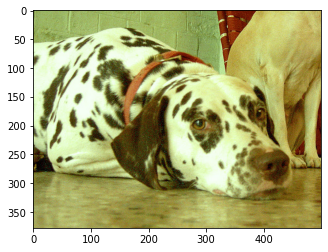

In [12]:
plt.imshow(mpimg.imread("./voc2012/VOC2012/JPEGImages/2011_002938.jpg"))
!cat voc2012/VOC2012/Annotations/2011_002938.xml

In [13]:
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

train_image_folder = "./voc2012/VOC2012/JPEGImages/"
train_annot_folder = "./voc2012/VOC2012/Annotations/"

Parse Annotations from the XML files and stores it in an array

In [14]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, labels = []):
    all_imgs = []
    seen_labels = {}

    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue

        img = {"object": []}

        tree = ET.parse(ann_dir + ann)

        for elem in tree.iter():
            if "filename" in elem.tag:
                path_to_image = img_dir + elem.text
                img["filename"] = path_to_image

                # make sure that the image exists:
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)

            if 'width' in elem.tag:
                    img['width'] = int(elem.text)

            if 'height' in elem.tag:
                img['height'] = int(elem.text)

            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}

                for attr in list(elem):
                    if "name" in attr.tag:
                        obj["name"] = attr.text
                    
                        if len(labels) > 0 and obj["name"] not in labels:
                            break
                        else:
                            img["object"] += [obj]
                        
                        if obj["name"] in seen_labels:
                            seen_labels[obj["name"]] += 1
                        else:
                            seen_labels[obj["name"]] = 1
                    
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img["object"]) > 0:
            all_imgs += [img]

    return all_imgs, seen_labels

In [15]:
train_image, seen_train_labels = parse_annotation(
    ann_dir = train_annot_folder,
    img_dir = train_image_folder,
    labels = LABELS
)

print("N train = {}".format(len(train_image)))

N train = 17125


In [16]:
train_image[:2]

[{'filename': './voc2012/VOC2012/JPEGImages/2007_000027.jpg',
  'height': 500,
  'object': [{'name': 'person',
    'xmax': 349,
    'xmin': 174,
    'ymax': 351,
    'ymin': 101}],
  'width': 486},
 {'filename': './voc2012/VOC2012/JPEGImages/2007_000032.jpg',
  'height': 281,
  'object': [{'name': 'aeroplane',
    'xmax': 375,
    'xmin': 104,
    'ymax': 183,
    'ymin': 78},
   {'name': 'aeroplane', 'xmax': 197, 'xmin': 133, 'ymax': 123, 'ymin': 88},
   {'name': 'person', 'xmax': 213, 'xmin': 195, 'ymax': 229, 'ymin': 180},
   {'name': 'person', 'xmax': 44, 'xmin': 26, 'ymax': 238, 'ymin': 189}],
  'width': 500}]

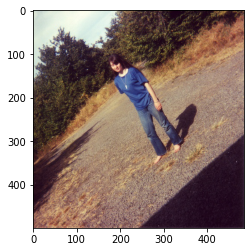

In [17]:
plt.imshow(mpimg.imread("./voc2012/VOC2012/JPEGImages/2007_000027.jpg"))

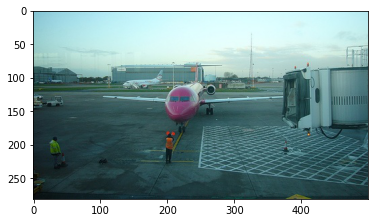

In [18]:
plt.imshow(mpimg.imread("./voc2012/VOC2012/JPEGImages/2007_000032.jpg"))

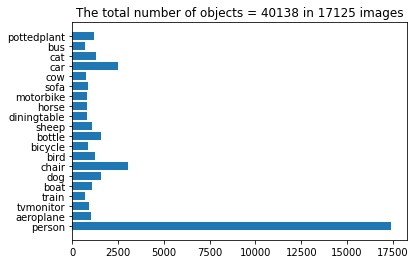

In [19]:
y_pos = np.arange(len(seen_train_labels))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.barh(y_pos,list(seen_train_labels.values()))
ax.set_yticks(y_pos)
ax.set_yticklabels(list(seen_train_labels.keys()))
ax.set_title("The total number of objects = {} in {} images".format(
    np.sum(list(seen_train_labels.values())),len(train_image)
))

plt.show()

### Standardize (width, height) data for K-means clustering

In [20]:
wh = []

for anno in train_image:
    aw = float(anno["width"]) # width of the original image
    ah = float(anno["height"]) # height of the original image

    for obj in anno["object"]:
        w = (obj["xmax"] - obj["xmin"]) / aw # make the width range between [0, GRID_W]
        h = (obj["ymax"] - obj["ymin"]) / aw # make the width range between [0, GRID_H]
        temp = [w, h]
        wh.append(temp)

wh = np.array(wh)
print("clustering feature data is ready. shape = (N object, width and height) =  {}".format(wh.shape))

clustering feature data is ready. shape = (N object, width and height) =  (40138, 2)


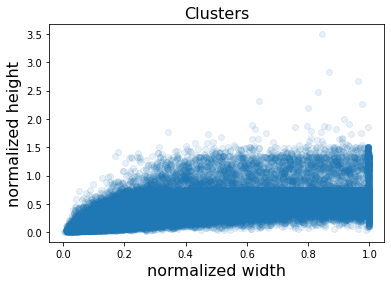

In [21]:
plt.scatter(wh[:,0], wh[:,1], alpha=0.1)
plt.title("Clusters", fontsize=16)
plt.xlabel("normalized width", fontsize=16)
plt.ylabel("normalized height", fontsize=16)
plt.show()

### Calculating IoU (Intersection over Union)

<img src="https://farm8.staticflickr.com/7813/46412972842_6d2af063e9_h.jpg" width=400 />

In [22]:
def iou(box, clusters):
    """
    :param box: np.array of shape (2,) containing w and h
    :param clusters: np.array of shape(N clusters, 2)
    """

    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    return intersection / (box_area + cluster_area - intersection)

### Understanding K-means clustering

In [23]:
def kmeans(boxes, k, dist = np.median, seed = 1):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)

    Steps:
    1. allocate each item to the closest cluster centers.
    2. calculate the cluster centers as mean (or median) of all the cases in the clusters.
    - Repeat steps 1 and 2 until the two consective iterations yield the same cluster centers.
    """

    rows = boxes.shape[0] # total number of boxes

    distances = np.empty((rows, k)) # N row x N clusters
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    # randomly chose k boxes and set those boxes as the center of clusters
    clusters = boxes[np.random.choice(rows, k, replace = False)]

    while True:
        # Step 1: allocate each item to the closest cluster centers
        for icluster in range(k):
            # find how much does the random cluster cover each boxes (objects from training)
            distances[:, icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis = 1)

        if (last_clusters == nearest_clusters).all():
            break

        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters, nearest_clusters, distances

In [24]:
# the more clusters, the larger mean IoU becomes

kmax = 11
dist = np.mean
results = {}

for k in range(2, kmax):
    clusters, nearest_clusters, distances = kmeans(wh, k, seed = 2, dist = dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]), nearest_clusters])

    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}

    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.4524
 3 clusters: mean IoU = 0.5210
 4 clusters: mean IoU = 0.5507
 5 clusters: mean IoU = 0.5789
 6 clusters: mean IoU = 0.5998
 7 clusters: mean IoU = 0.6214
 8 clusters: mean IoU = 0.6326
 9 clusters: mean IoU = 0.6487
10 clusters: mean IoU = 0.6616


Visualize K-means results

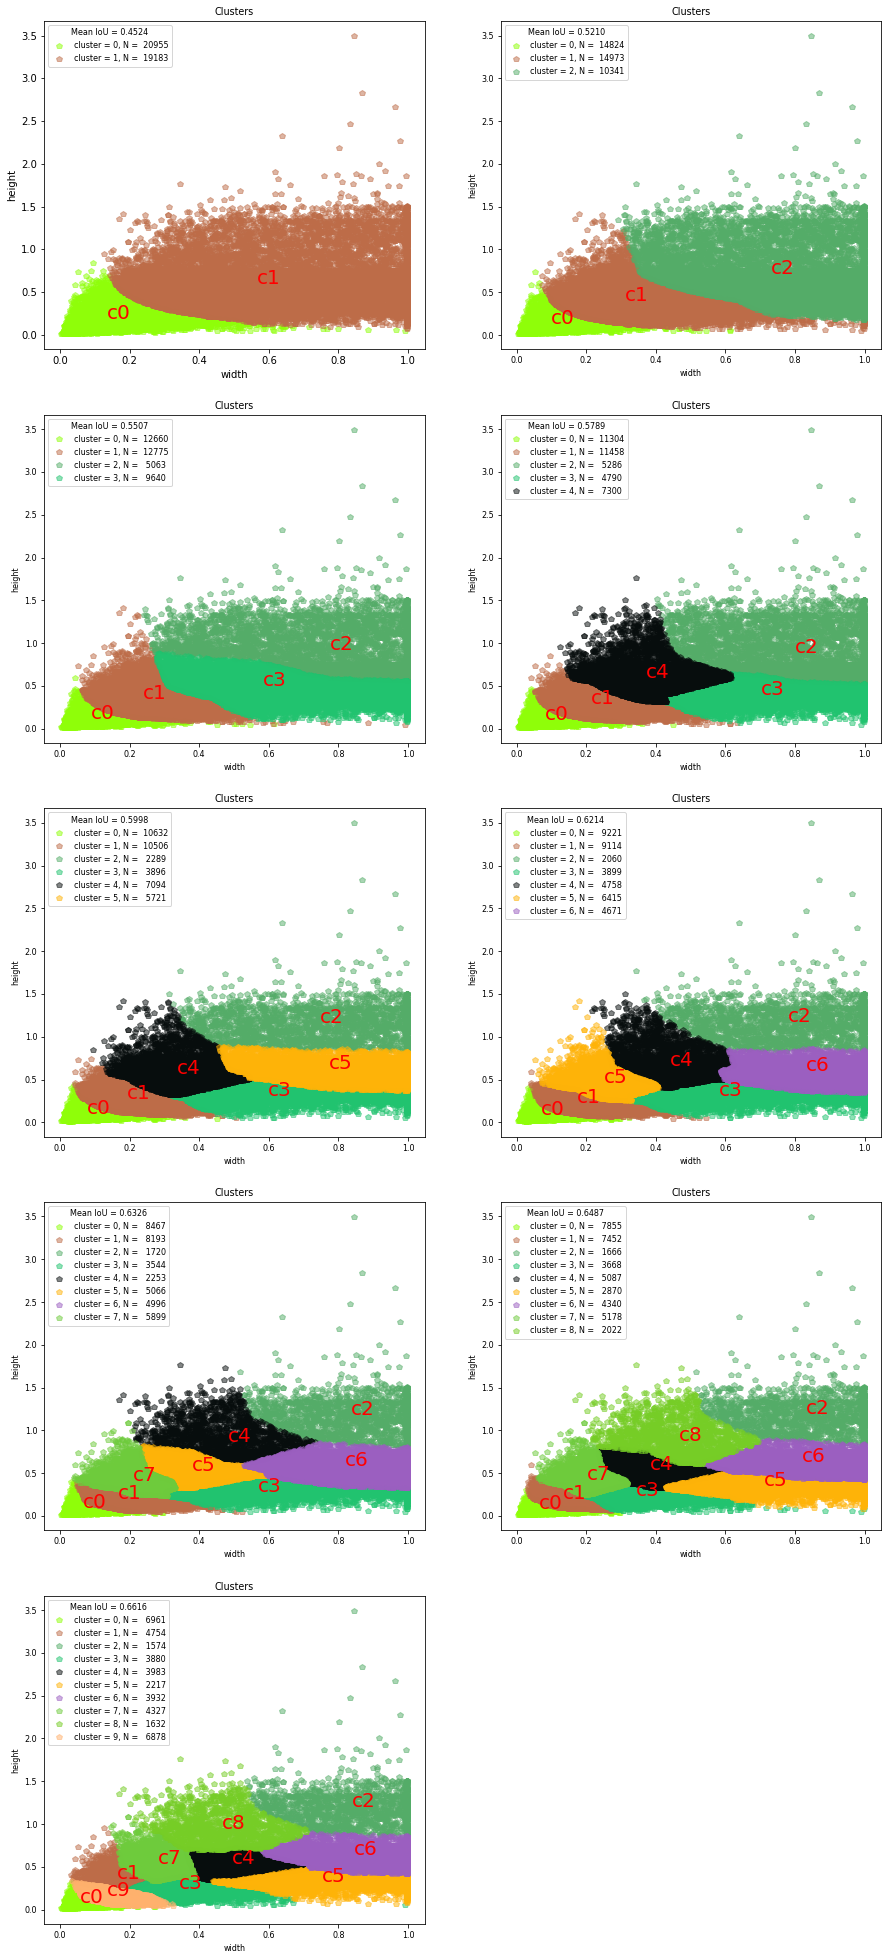

In [25]:
def plot_cluster_result(plt,clusters,nearest_clusters,WithinClusterSumDist,wh):
    for icluster in np.unique(nearest_clusters):
        pick = nearest_clusters==icluster
        c = current_palette[icluster]
        plt.rc('font', size=8) 
        plt.plot(wh[pick,0],wh[pick,1],"p",
                 color=c,
                 alpha=0.5,label="cluster = {}, N = {:6.0f}".format(icluster,np.sum(pick)))
        plt.text(clusters[icluster,0],
                 clusters[icluster,1],
                 "c{}".format(icluster),
                 fontsize=20,color="red")
        plt.title("Clusters")
        plt.xlabel("width")
        plt.ylabel("height")
    plt.legend(title="Mean IoU = {:5.4f}".format(WithinClusterSumDist))  

import seaborn as sns
current_palette = list(sns.xkcd_rgb.values())

figsize = (15,35)
count =1 
fig = plt.figure(figsize=figsize)
for k in range(2,kmax):
    result               = results[k]
    clusters             = result["clusters"]
    nearest_clusters     = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2,2,count)
    plot_cluster_result(plt,clusters,nearest_clusters,1 - WithinClusterSumDist,wh)
    count += 1
plt.show()

Elbow curse to see how many anchor boxes to use (mean IoU vs N clusters)

- the true number of clusters is captuered when the increase in the mean IoU    slope is "substantially" large.

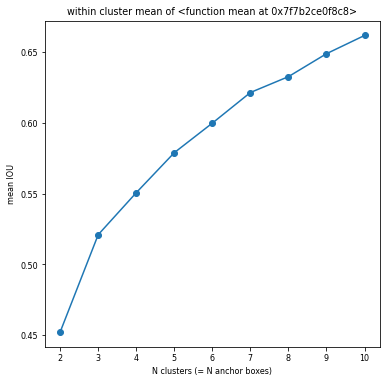

In [26]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(2,kmax),
         [1 - results[k]["WithinClusterMeanDist"] for k in range(2,kmax)],"o-")
plt.title("within cluster mean of {}".format(dist))
plt.ylabel("mean IOU")
plt.xlabel("N clusters (= N anchor boxes)")
plt.show()

In [27]:
Nanchor_box = 4
results[Nanchor_box]["clusters"] # 4 achor boxes, [w, h]

array([[0.08753443, 0.11417549],
       [0.23666794, 0.34744943],
       [0.77528592, 0.92358465],
       [0.58232535, 0.49502078]])

<br/>

# 2. Input and Output Encoding

https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html

### Input Encoding

ImageReader is to resize image to given input shape and also normalize the image if normalization method is given.

In [28]:
import copy

class ImageReader(object):
    def __init__(self, IMAGE_H, IMAGE_W, norm = None):
        """
        IMAGE_H: the height of the rescaled image, e.g., 416
        IMAGE_W: the width of the rescaled image, e.g., 416
        """

        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.norm = norm

    def encode_core(self, image, reorder_rgb = True):
        # resize the image to standard size
        image = cv2.resize(image, (self.IMAGE_H, self.IMAGE_W))
        if reorder_rgb:
            image = image[:, :, ::-1]
        if self.norm is not None:
            image = self.norm(image)

        return image

    def fit(self, train_instance):
        """
        read in and resize the image, annotations are resized accordingly.

        --- Input ---

        train_instance : dictionary containing filename, height, width and object
        
        {'filename': 'ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/2008_000054.jpg',
         'height':   333,
         'width':    500,
         'object': [{'name': 'bird',
                     'xmax': 318,
                     'xmin': 284,
                     'ymax': 184,
                     'ymin': 100},
                    {'name': 'bird', 
                     'xmax': 198, 
                     'xmin': 112, 
                     'ymax': 209, 
                     'ymin': 146}]
        }
        """

        if not isinstance(train_instance,dict):
            train_instance = {'filename':train_instance}

        image_name = train_instance['filename']
        image = cv2.imread(image_name)

        h, w, c = image.shape
        if image is None:
            print('Cannot find ', image_name)

        image = self.encode_core(image, reorder_rgb = True)

        # all objects in bounding boxes
        if "object" in train_instance.keys():
            all_objs = copy.deepcopy(train_instance["object"])

            # fix object's position and size
            # rescale xmin, xmax, ymin, ymax annotations
            # how it rescale:
            #     - if width I -> position a
            #     - if width J -> (position a * width J) / width I = position b
            #     - if position b > width J -> position b = width J
            #     - if position b < 0 -> position b = 0
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image

        return image, all_objs

In [29]:
def normalize(image):
    return image / 255

******************************
Input
  object: [{'name': 'person', 'xmin': 174, 'ymin': 101, 'xmax': 349, 'ymax': 351}]
  filename: ./voc2012/VOC2012/JPEGImages/2007_000027.jpg
  width: 486
  height: 500
******************************
Output
  [{'name': 'person', 'xmin': 148, 'ymin': 84, 'xmax': 298, 'ymax': 292}]


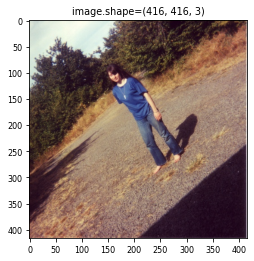

In [30]:
print("*"*30)
print("Input")

timage = train_image[0]

for key, v in timage.items():
    print("  {}: {}".format(key,v))

print("*"*30)
print("Output")

inputEncoder = ImageReader(IMAGE_H=416, IMAGE_W=416, norm=normalize)
image, all_objs = inputEncoder.fit(timage)
print("  {}".format(all_objs))

plt.imshow(image)
plt.title("image.shape={}".format(image.shape))
plt.show()

BestAnchorBoxFinder is to find the anchor box that gives the highest IoU to the object.

- In first part we decided to use 4 different anchor boxes.

In [31]:
class BestAnchorBoxFinder(object):
    def __init__(self, ANCHORS):
        """
        ANCHORS: a np.array of even number length e.g.
        
        _ANCHORS = [4,2, ##  width=4, height=2,  flat large anchor box
                    2,4, ##  width=2, height=4,  tall large anchor box
                    1,1] ##  width=1, height=1,  small anchor box
        """
        self.anchors = [BoundBox(0, 0, ANCHORS[2 * i], ANCHORS[2 * i + 1])
                        for i in range(int(len(ANCHORS) // 2))]

    def _interval_overlap(self, interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b

        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2, x4) - x1
        else:
            if x2 < x3:
                return 0
            else:
                return min(x2, x4) - x3

    def bbox_iou(self, box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

        intersect = intersect_w * intersect_h

        w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
        w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin

        union = w1*h1 + w2*h2 - intersect
        return float(intersect) / union

    def find(self, center_w, center_h):
        # find the best anchor that best predicts the box
        best_anchor = -1
        max_iou = -1

        # each Anchor box is specialized to have a certain shape
        # e.g., flat large rectangle, or small square
        shifted_box = BoundBox(0, 0, center_w, center_h)

        # For given object, find the best anchor box!
        for i in range(len(self.anchors)): ## run through each anchor box
            anchor = self.anchors[i]
            iou    = self.bbox_iou(shifted_box, anchor)

            if max_iou < iou:
                best_anchor = i
                max_iou     = iou

        return best_anchor, max_iou

In [32]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, confidence = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        # the code below are used during inference probability
        self.confidence = confidence

        # class probabilities [c1, c2, .. cNclass]
        self.set_class(classes)

    def set_class(self, classes):
        self.classes = classes
        self.label = np.argmax(self.classes)

    def get_label(self):
        return self.label

    def get_score(self):
        return self.classes[self.label]

In [33]:
_ANCHORS01 = np.array([0.08285376, 0.13705531,
                       0.20850361, 0.39420716,
                       0.80552421, 0.77665105,
                       0.42194719, 0.62385487])

print(".." * 40)
print("The three example anchor boxes:")

count = 0
for i in range(0, len(_ANCHORS01), 2):
    print("anchor box index={}, w={}, h={}".format(count, _ANCHORS01[i], _ANCHORS01[i+1]))
    count += 1

print(".." * 40)   
print("Allocate bounding box of various width and height into the three anchor boxes:")  

babf = BestAnchorBoxFinder(_ANCHORS01)

for w in range(1, 9, 2):
    w /= 10.

    for h in range(1, 9, 2):
        h /= 10.
        best_anchor, max_iou = babf.find(w, h)
        print("bounding box (w = {}, h = {}) --> best anchor box index = {}, iou = {:03.2f}".format(
            w, h, best_anchor, max_iou)
        )

................................................................................
The three example anchor boxes:
anchor box index=0, w=0.08285376, h=0.13705531
anchor box index=1, w=0.20850361, h=0.39420716
anchor box index=2, w=0.80552421, h=0.77665105
anchor box index=3, w=0.42194719, h=0.62385487
................................................................................
Allocate bounding box of various width and height into the three anchor boxes:
bounding box (w = 0.1, h = 0.1) --> best anchor box index = 0, iou = 0.63
bounding box (w = 0.1, h = 0.3) --> best anchor box index = 0, iou = 0.38
bounding box (w = 0.1, h = 0.5) --> best anchor box index = 1, iou = 0.42
bounding box (w = 0.1, h = 0.7) --> best anchor box index = 1, iou = 0.35
bounding box (w = 0.3, h = 0.1) --> best anchor box index = 0, iou = 0.25
bounding box (w = 0.3, h = 0.3) --> best anchor box index = 1, iou = 0.57
bounding box (w = 0.3, h = 0.5) --> best anchor box index = 3, iou = 0.57
bounding box (w = 0.3

### Output Encoding

In VOC2012 input encoding, each object in a frame is recorded in xmin, ymin, xmax and ymax coordiante formats.

`[{'name': 'person', 'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}]`

In YOLO, outputs of YOLO encodes the bounding box coordinates in the 'center_x', 'center_y', 'center_w', 'center_h' format as:

`[{'name': 'person', 'center_x':225, 'center_y': 210, 'center_w': 150, 'center_h': 189}]`


![image](https://live.staticflickr.com/4907/45752792674_eea0c27a3b.jpg)

In [34]:
def rescale_centerxy(obj, config):
    """
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    """

    center_x = 0.5 * (obj["xmin"] + obj["xmax"])
    center_x = center_x * config['GRID_W'] / float(config['IMAGE_W'])

    center_y = 0.5 * (obj['ymin'] + obj['ymax'])
    center_y = center_y * config['GRID_H'] / float(config['IMAGE_H'])

    return center_x, center_y

In [35]:
def rescale_centerwh(obj,config):
    """
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    """

    # unit: grid cell
    center_w = (obj['xmax'] - obj['xmin']) * config['GRID_W'] / float(config['IMAGE_W'])

    # unit: grid cell
    center_h = (obj['ymax'] - obj['ymin']) * config['GRID_H'] / float(config['IMAGE_H'])

    return center_w, center_h

In [36]:
obj    = {'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}
config = {"IMAGE_W": 416, "IMAGE_H": 416, "GRID_W": 13, "GRID_H": 13}

center_x, center_y = rescale_centerxy(obj, config)
center_w, center_h = rescale_centerwh(obj, config)

print("center_x and center_w should range between 0 and {}".format(config["GRID_W"]))
print("center_y and center_h should range between 0 and {}".format(config["GRID_H"]))

print("center_x = {:06.3f} range between 0 and {}".format(center_x, config["GRID_W"]))
print("center_y = {:06.3f} range between 0 and {}".format(center_y, config["GRID_H"]))
print("center_w = {:06.3f} range between 0 and {}".format(center_w, config["GRID_W"]))
print("center_h = {:06.3f} range between 0 and {}".format(center_h, config["GRID_H"]))

center_x and center_w should range between 0 and 13
center_y and center_h should range between 0 and 13
center_x = 07.031 range between 0 and 13
center_y = 05.906 range between 0 and 13
center_w = 04.688 range between 0 and 13
center_h = 06.562 range between 0 and 13


## Keras's BatchGenerator

Our Input Shape is (N images, height, width, N channels) = (17125, 416, 416, 3 [rgb])

**Input batch** `x_batch` = (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)

**Output batch** `y_batch` = (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes)

> BOX = The number of anchor boxes  
> 4 in `y_batch` is `center_x`, `center_y`, `center_W`, `center_H`  
> 1 in `y_batch` is `0` or `1` to indicate if there's an image or not  
> N in `y_batch` is one hot encoding vector for classes  


In [37]:
from tensorflow.keras.utils import Sequence

class SimpleBatchGenerator(Sequence):
    def __init__(self, images, config, norm = None, shuffle = True):
        '''
        config : dictionary containing necessary hyper parameters for traning. e.g., 
            {
            'IMAGE_H'         : 416, 
            'IMAGE_W'         : 416,
            'GRID_H'          : 13,  
            'GRID_W'          : 13,
            'LABELS'          : ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                                  'bus',        'car',      'cat',  'chair',     'cow',
                                  'diningtable','dog',    'horse',  'motorbike', 'person',
                                  'pottedplant','sheep',  'sofa',   'train',   'tvmonitor'],
            'ANCHORS'         : array([ 1.07709888,   1.78171903,  
                                        2.71054693,   5.12469308, 
                                        10.47181473, 10.09646365,  
                                        5.48531347,   8.11011331]),
            'BATCH_SIZE'      : 16,
            'TRUE_BOX_BUFFER' : 50,
            }
        
        '''

        self.config = config
        self.config["BOX"] = int(len(self.config['ANCHORS']) / 2)
        self.config["CLASS"] = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'], config['IMAGE_W'], norm=norm)
        self.shuffle = shuffle

        if self.shuffle:
            np.random.shuffle(self.images)
    
    def __len__(self):
        images_len = float(len(self.images))
        return int(np.ceil(images_len / self.config['BATCH_SIZE']))  

    def __getitem__(self, idx):
        '''
        == input == 
        
        idx : non-negative integer value e.g., 0
        
        == output ==
        
        x_batch: The numpy array of shape  (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels).
            
            x_batch[iframe,:,:,:] contains a iframeth frame of size  (IMAGE_H,IMAGE_W).
            
        y_batch:

            The numpy array of shape  (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes). 
            BOX = The number of anchor boxes.

            y_batch[iframe,igrid_h,igrid_w,ianchor,:4] contains (center_x,center_y,center_w,center_h) 
            of ianchorth anchor at  grid cell=(igrid_h,igrid_w) if the object exists in 
            this (grid cell, anchor) pair, else they simply contain 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,4] contains 1 if the object exists in this 
            (grid cell, anchor) pair, else it contains 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,5 + iclass] contains 1 if the iclass^th 
            class object exists in this (grid cell, anchor) pair, else it contains 0.


        b_batch:

            The numpy array of shape (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4).

            b_batch[iframe,1,1,1,ibuffer,ianchor,:] contains ibufferth object's 
            (center_x,center_y,center_w,center_h) in iframeth frame.

            If ibuffer > N objects in iframeth frame, then the values are simply 0.

            TRUE_BOX_BUFFER has to be some large number, so that the frame with the 
            biggest number of objects can also record all objects.

            The order of the objects do not matter.

            This is just a hack to easily calculate loss. 
        
        '''
        l_bound = idx * self.config["BATCH_SIZE"]
        r_bound = (idx + 1) * self.config["BATCH_SIZE"]

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config["BATCH_SIZE"]

        instance_count = 0

        # prepare empty storage space: this will be output
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3)) # input images
        b_batch = np.zeros((r_bound - l_bound, 1, 1, 1, self.config['TRUE_BOX_BUFFER'], 4)) # list of self.config['TRUE_BOX_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'], self.config['GRID_W'], self.config['BOX'], 4 + 1 + len(self.config['LABELS']))) # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.imageReader.fit(train_instance)

            # construct output from object's x, y, w, h
            true_box_index = 0

            """
            TLDR; from training data, we have xmax, xmin, ymax, ymin

            1. First, we get center_x, center_y from the 4 parameters mentioned above and rescaled those into grid scale
               by calling `rescale_centerxy`
               Also when you floor those center_x and center_y, we know which grid cell its belong to
                For example, if there's total 13 horizontal grids and center_x is 7.5, floors to 7
                means that object with center_x value 7.5 belong to grid 7 in the image.

            2. Later, we use `rescale_centerwh` to get center_w, center_h for the boundaries of the object
               from Step 1 and Step 2, we got width, height, x and y position of the center
               technically, we can draw the rectangular bounder on the object in the image already

            3. So after we got those 4 center values, we use to find the best match (highest IoU) anchor box
               from 4 predefined anchor boxes (we got using K-means clustering)
               With that we got the Y (output value) for the training data
            """

            for obj in all_objs:
                if obj["xmax"] > obj["xmin"] and obj["ymax"] > obj["ymin"] and obj["name"] in self.config["LABELS"]:
                    # rescale the center x, y into grid cell scale
                    center_x, center_y = rescale_centerxy(obj, self.config)

                    grid_x = int(np.floor(center_x)) # get x grid number
                    grid_y = int(np.floor(center_y)) # get y grid number

                    # if less than max W and H grid number, correct scale
                    if grid_x < self.config["GRID_W"] and grid_y < self.config["GRID_H"]:
                        obj_indx = self.config["LABELS"].index(obj["name"])

                        center_w, center_h = rescale_centerwh(obj, self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor, max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)

                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        # it could happen that the same grid cell contain 2 similar shape objects
                        # as a result the same anchor box is selected as the best anchor box by the multiple objects
                        # in such ase, the object is over written
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box # center_x, center_y, w, h
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1. # ground truth confidence is 1

                        # it is one hot encoding so, the other remaining indices is 0 and only
                        # the index that is the same as obj_index from config["LABELS"] will be 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5 + obj_indx] = 1 # class probability of the object


                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']

            x_batch[instance_count] = img
            # increase instance counter in current batch
            instance_count += 1 
        
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.images)

Adjust anchor boxes width and height to be in the grid scales as the bounding box's `center_w` and `center_h` are in the grid cell scales.

In [38]:
_ANCHORS01

array([0.08285376, 0.13705531, 0.20850361, 0.39420716, 0.80552421,
       0.77665105, 0.42194719, 0.62385487])

In [39]:
GRID_H,  GRID_W  = 13 , 13
ANCHORS          = _ANCHORS01
ANCHORS[::2]     = ANCHORS[::2] * GRID_W  
ANCHORS[1::2]    = ANCHORS[1::2] * GRID_H  
ANCHORS

array([ 1.07709888,  1.78171903,  2.71054693,  5.12469308, 10.47181473,
       10.09646365,  5.48531347,  8.11011331])

In [40]:
IMAGE_H, IMAGE_W = 416, 416
BATCH_SIZE       = 16
TRUE_BOX_BUFFER  = 50
BOX = int(len(ANCHORS) / 2)
CLASS = len(LABELS)

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}

In [41]:
train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

[x_batch, b_batch], y_batch = train_batch_generator.__getitem__(idx=3)

In [42]:
x_batch[0, :, :, :].shape

(416, 416, 3)

In [43]:
y_batch[0, :, :, :].shape

# 13x13 is grid
# 4 is anchor boxes
# 25 is center_x, center_y, center_W, center_H, {0:1} to tell if the given anchor box is for that object, remaining is one hot encoding for type of object

(13, 13, 4, 25)

In [44]:
b_batch[0, :, :, :].shape

# first axis is the ith instance from the batch
# last index is the ground truth center_x, center_y, center_W, center_H boundries of the object

(1, 1, 1, 50, 4)

Input/Output shape

In [45]:
print("x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {}".format(x_batch.shape))
print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(y_batch.shape))
print("b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {}".format(b_batch.shape))

x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (16, 416, 416, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = (16, 13, 13, 4, 25)
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = (16, 1, 1, 1, 50, 4)


In [46]:
generator_config

{'ANCHORS': array([ 1.07709888,  1.78171903,  2.71054693,  5.12469308, 10.47181473,
        10.09646365,  5.48531347,  8.11011331]),
 'BATCH_SIZE': 16,
 'BOX': 4,
 'CLASS': 20,
 'GRID_H': 13,
 'GRID_W': 13,
 'IMAGE_H': 416,
 'IMAGE_W': 416,
 'LABELS': ['aeroplane',
  'bicycle',
  'bird',
  'boat',
  'bottle',
  'bus',
  'car',
  'cat',
  'chair',
  'cow',
  'diningtable',
  'dog',
  'horse',
  'motorbike',
  'person',
  'pottedplant',
  'sheep',
  'sofa',
  'train',
  'tvmonitor'],
 'TRUE_BOX_BUFFER': 50}

In [47]:
iframe= 12

def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):

                # get last index, 25 rows in total
                # 0-3 is x, y, W, H
                # 4 is {0:1} to indicate if there's an image or not
                # the rest indices is one hot encoding of the object category
                vec = y_batch[irow, igrid_h, igrid_w, ianchor, :]
                C = vec[4] # ground truth confidence

                if C == 1:
                    # only one row will be 1 and the rest is 0
                    # so by using WHERE, from all labels, it only filters one label
                    # to get class name
                    class_nm = np.array(LABELS)[np.where(vec[5:])]

                    # since ground truth confidence is 1, there's must be one class name
                    assert len(class_nm) == 1

                    print("igrid_h={:02.0f}, igrid_w={:02.0f}, iAnchor={:02.0f}, {}".format(
                        igrid_h, igrid_w, ianchor, class_nm[0])
                    )

check_object_in_grid_anchor_pair(iframe)

igrid_h=05, igrid_w=00, iAnchor=00, pottedplant
igrid_h=05, igrid_w=12, iAnchor=00, pottedplant
igrid_h=06, igrid_w=04, iAnchor=00, tvmonitor
igrid_h=06, igrid_w=10, iAnchor=00, pottedplant
igrid_h=06, igrid_w=12, iAnchor=00, pottedplant
igrid_h=08, igrid_w=02, iAnchor=01, chair
igrid_h=09, igrid_w=00, iAnchor=00, chair
igrid_h=10, igrid_w=08, iAnchor=02, sofa


### Visualize the output of the BatchGenerator

In [48]:
def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow]
    plt.figure(figsize=(15,15))
    plt.imshow(img)

    for wh in ["W", "H"]:
        GRID_  = generator_config["GRID_"  + wh] # 13
        IMAGE_ = generator_config["IMAGE_" + wh] # 416

        if wh == "W":
            pltax   = plt.axvline
            plttick = plt.xticks
        else:
            pltax   = plt.axhline
            plttick = plt.yticks

        # for range between 1 to GRID length
        for count in range(GRID_):
            l = IMAGE_ * count / GRID_
            pltax(l, color = "yellow", alpha=0.3)

        plttick(
            [(i + 0.5) * IMAGE_ / GRID_ for i in range(GRID_)],
            ["iGRID{}={}".format(wh, i) for i in range(GRID_)]
        )

In [49]:
def plot_grid(irow):
    import seaborn as sns
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0

    # loop by vertical grid
    for igrid_h in range(generator_config["GRID_H"]):

        # loop by horizontal grid
        for igrid_w in range(generator_config["GRID_W"]):

            # loop by anchor boxes (4 boxes)
            for ianchor in range(generator_config["BOX"]):

                # get x, y, w, h, confidence, and ... remaining one hot encoding of category
                vec = y_batch[irow, igrid_h, igrid_w, ianchor, :]
                C = vec[4] # ground truth confidence

                # if confidence is 1 for the anchor box
                if C == 1:
                    # get one hot encoding of category
                    class_nm = np.array(LABELS)[np.where(vec[5:])]

                    # get center_x, center_y, center_w, center_h
                    x, y, w, h = vec[:4]

                    # 'GRID_H': 13,
                    # 'GRID_W': 13,
                    # 'IMAGE_H': 416,
                    # 'IMAGE_W': 416,
                    # because x, y, w, h are in grid scale, if we know length of orignal image if grid is 1
                    # we can get length of the position, if the position is x grid by multiplying x and multx for example
                    multx = generator_config["IMAGE_W"] / generator_config["GRID_W"] # find length of IMAGE_W if GRID_W is 1
                    multy = generator_config["IMAGE_H"] / generator_config["GRID_H"] # find length of IMAGE_H if GRID_W is 1

                    c = color_palette[iobj]
                    iobj += 1
                    xmin = x - 0.5 * w
                    ymin = y - 0.5 * h
                    xmax = x + 0.5 * w
                    ymax = y + 0.5 * h

                    # center
                    plt.text(x * multx, y * multy, "X", color = c,fontsize = 23)

                    # left vertical line
                    plt.plot(
                        np.array([xmin, xmin]) * multx,
                        np.array([ymin, ymax]) * multy,
                        color = c,
                        linewidth = 10
                    )

                    # top horizontal line
                    plt.plot(
                        np.array([xmin, xmax]) * multx,
                        np.array([ymin, ymin]) * multy,
                        color = c,
                        linewidth = 10
                    )

                    # right vertical line
                    plt.plot(
                        np.array([xmax, xmax]) * multx,
                        np.array([ymax, ymin]) * multy,
                        color = c,
                        linewidth = 10
                    )
  
                    # bottom horizontal line
                    plt.plot(
                        np.array([xmin, xmax]) * multx,
                        np.array([ymax, ymax]) * multy,
                        color = c,
                        linewidth = 10
                    )

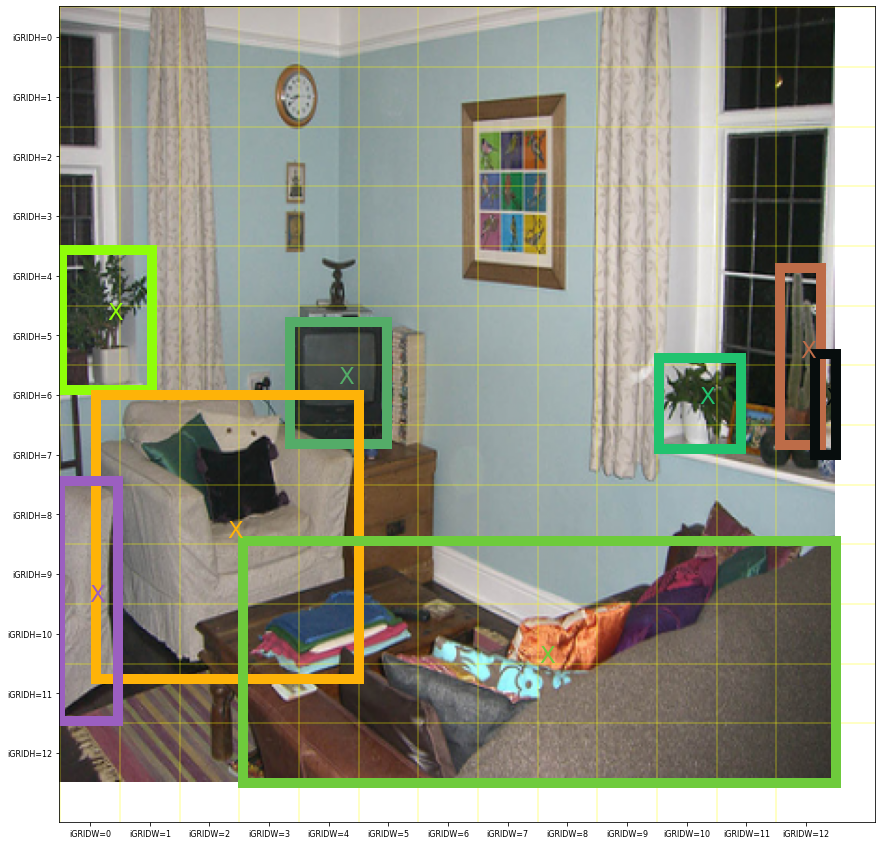

In [50]:
plot_image_with_grid_cell_partition(iframe)
plot_grid(iframe)
plt.show()

------------------------------
igrid_h=06, igrid_w=08, iAnchor=02, bus
igrid_h=08, igrid_w=02, iAnchor=01, person
igrid_h=08, igrid_w=05, iAnchor=00, person
igrid_h=09, igrid_w=03, iAnchor=01, person


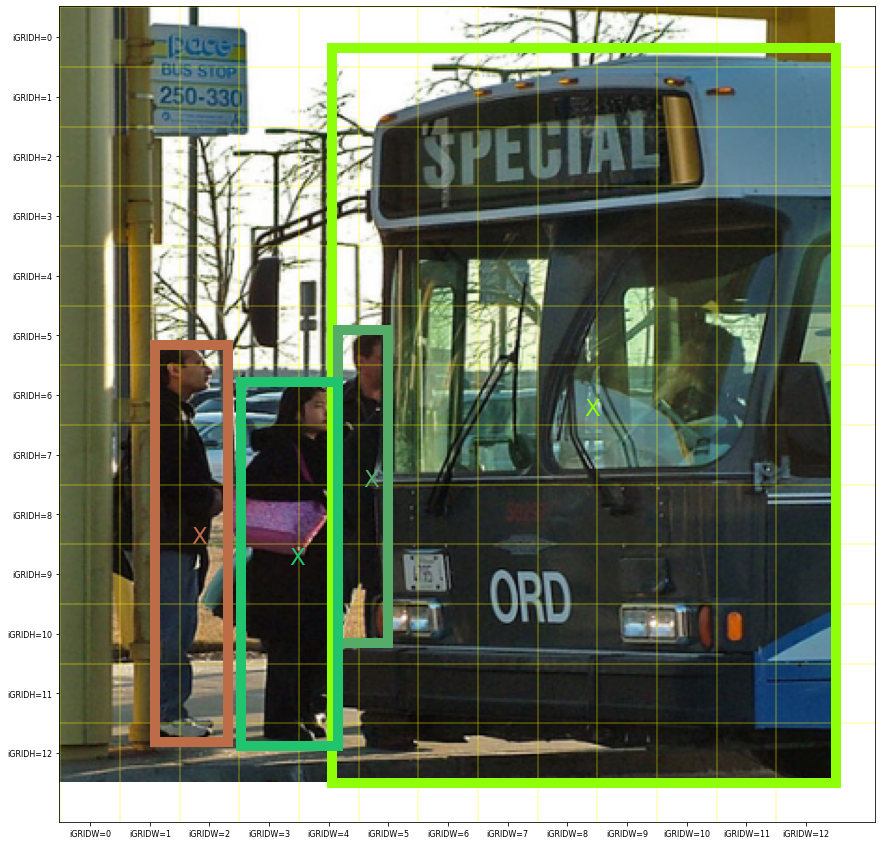

------------------------------
igrid_h=07, igrid_w=05, iAnchor=03, boat
igrid_h=09, igrid_w=08, iAnchor=00, person
igrid_h=09, igrid_w=09, iAnchor=00, person


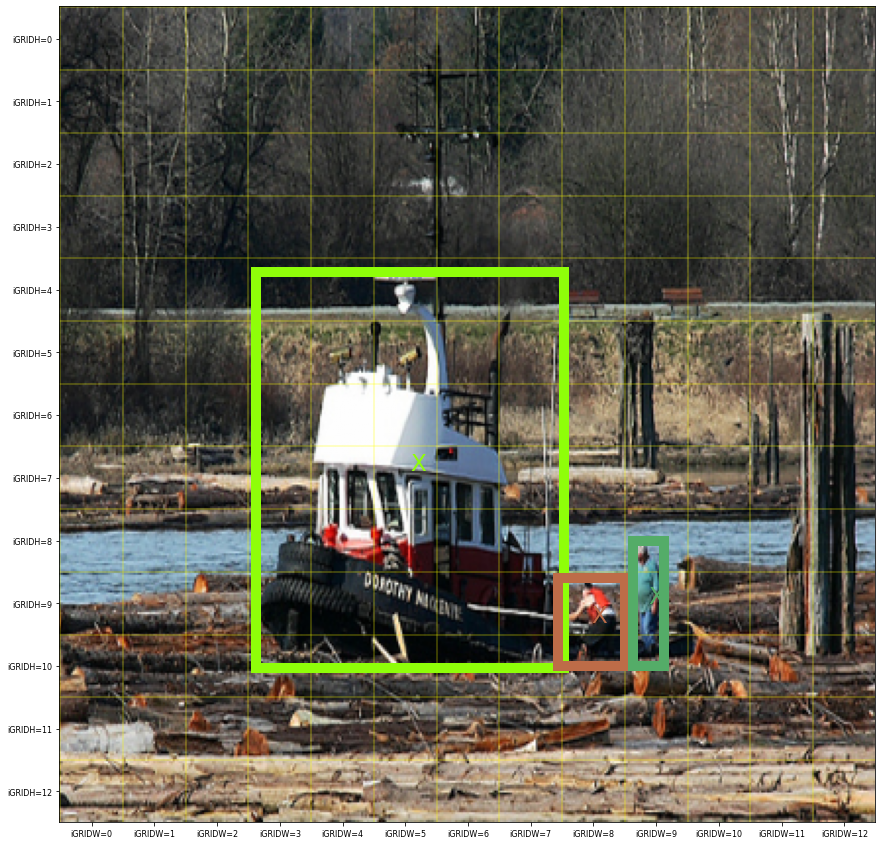

------------------------------
igrid_h=06, igrid_w=03, iAnchor=01, person
igrid_h=06, igrid_w=08, iAnchor=01, person


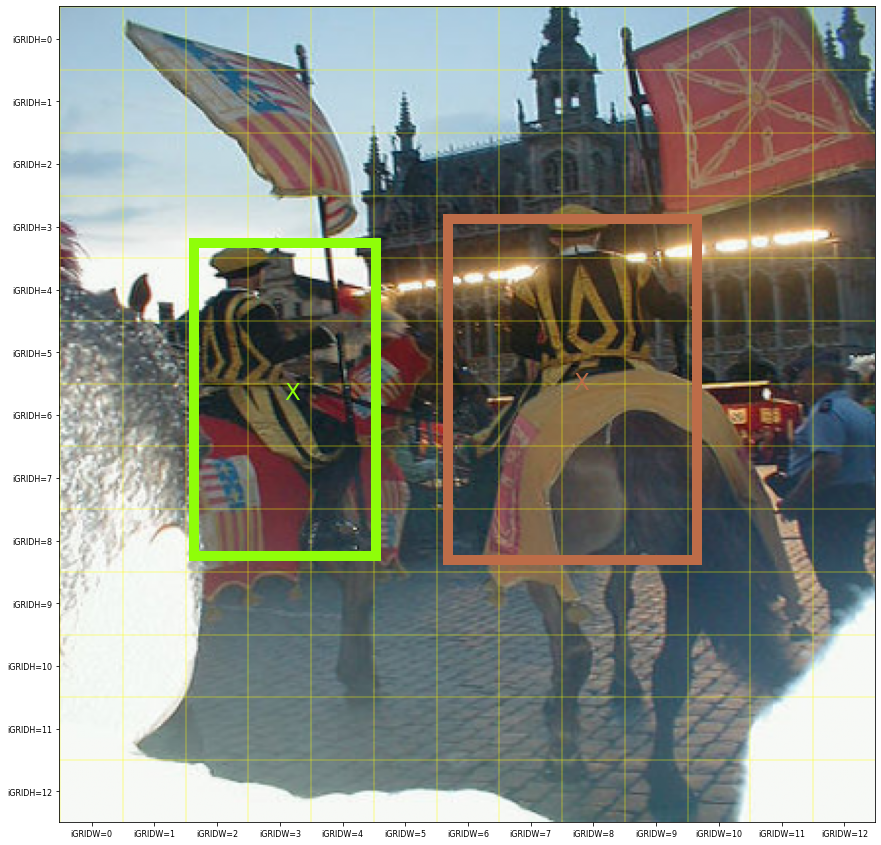

------------------------------
igrid_h=04, igrid_w=05, iAnchor=00, car
igrid_h=04, igrid_w=11, iAnchor=00, car
igrid_h=06, igrid_w=07, iAnchor=02, person
igrid_h=08, igrid_w=06, iAnchor=02, bicycle


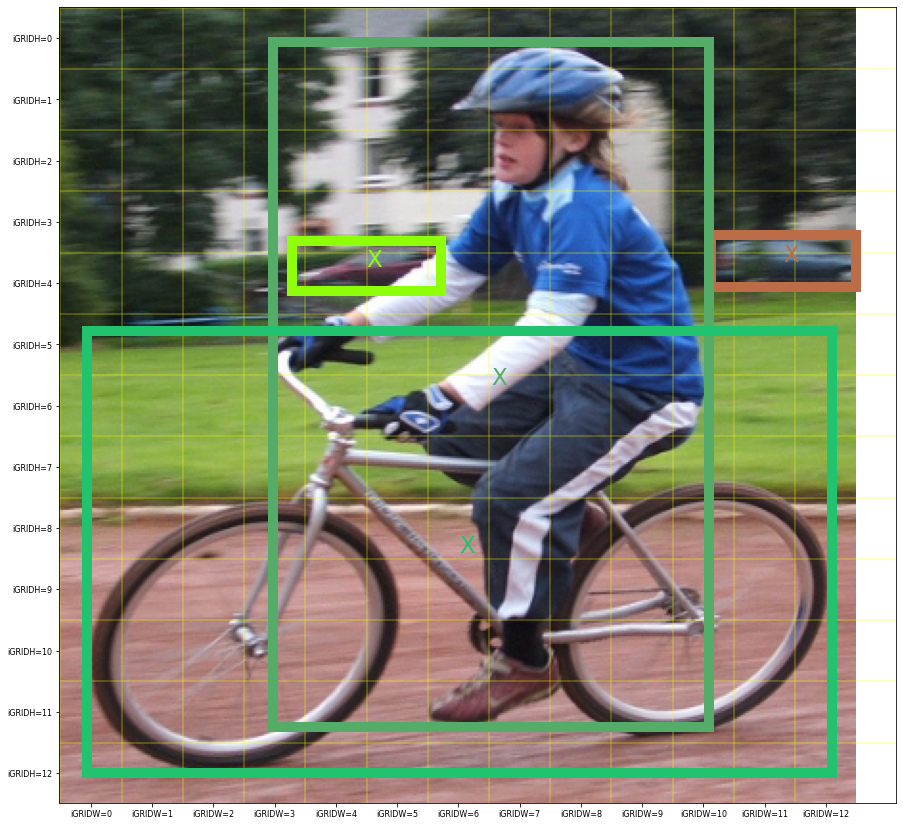

------------------------------
igrid_h=06, igrid_w=04, iAnchor=02, person
igrid_h=11, igrid_w=03, iAnchor=01, bottle


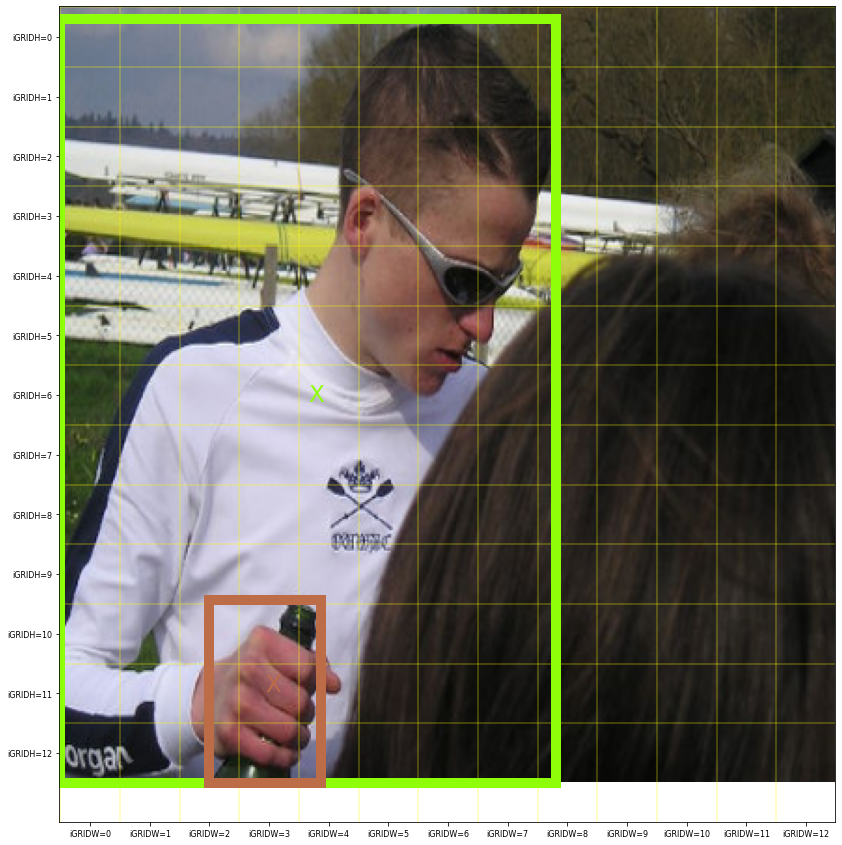

In [51]:
for irow in range(5,10):
    print("-"*30)
    check_object_in_grid_anchor_pair(irow)
    plot_image_with_grid_cell_partition(irow)
    plot_grid(irow)
    plt.show()

<br/>

# 3. Training The Model

https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2012_data_model.html

We will be making `Darknet-19` model

<img src="https://www.maskaravivek.com/img/YOLOV2.png" width="500"/>

In [52]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, LeakyReLU, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow as tf

# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size = 2)

input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER, 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
# shape is total anchor boxes [4 boxes we chose with K-means clustering] * (4 [w, h, x, y], 1 [confidence probability], CLASSES [20 in this case, number of categories])
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           norm_1[0][0]                     
_______________________________________________________________________________________

Load pre-trained YOLOv2 weights

In [53]:
!ls gdrive/My\ Drive/Colab\ Data/

PascalVOC2012.zip  yolov2.weights


In [54]:
path_to_weight = "./gdrive/My Drive/Colab Data/yolov2.weights"

In [55]:
class WeightReader:
    # code from https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype="float32")
    
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset - size: self.offset]

    def reset(self):
        self.offset = 4

weight_reader = WeightReader(path_to_weight)
print("all_weights.shape = {}".format(weight_reader.all_weights.shape))

all_weights.shape = (50983565,)


In [56]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv + 1):
    conv_layer = model.get_layer('conv_' + str(i))

    # because for layer 1-22, there's batchnorm layer, so need to set weight for norm layers
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))

        size = np.prod(norm_layer.get_weights()[0].shape) # channel/filter shape

        beta = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean = weight_reader.read_bytes(size)
        var = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])

    if len(conv_layer.get_weights()) > 1: # with bias
        # for convolution layer; 0 is kernel shape; 1 is for bias
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])

        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])

        conv_layer.set_weights([kernel])

In [57]:
layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

# set random weights and bias for last 4 layers that we plugged-in at the bottom for the model
# NOTE: i have not read the rest of the blog yet; I believe what we are going to do is
# transfer learning, means the rest of the kernel will be freezed with pretrained weight
# and the network will only be trained on the last 4 layers
new_kernel = np.random.normal(size=weights[0].shape) / (GRID_H * GRID_W)
new_bias   = np.random.normal(size=weights[1].shape) / (GRID_H * GRID_W)

layer.set_weights([new_kernel, new_bias])

<br/>

# 4. Loss Function

https://fairyonice.github.io/Part_4_Object_Detection_with_Yolo_using_VOC_2012_data_loss.html

Global hyperparameters necessary for the loss function

- true_boxes
- GRID_W
- GRID_H
- BATCH_SIZE
- ANCHORS
- LAMBDA_COORD
- LAMBDA_CLASS
- LAMBDA_NO_OBJECT
- LAMBDA_OBJECT

In [58]:
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT = 5.0
LAMBDA_COORD = 1.0
LAMBDA_CLASS = 1.0

Rescale prediction output

1. $x^{i, j}$ ranges between `igrid_w, igrid_w + 1`
2. $y^{i, j}$ ranges between `igrid_h, igrid_h + 1`
3. $w^{i, j}$ ranges between `0, GRID_W`
4. $h^{i, j}$ ranges between `0, GRID_H`
5. $C^{i, j}$ ranges between `0 and 1`
6. $p_c^{i,j}$ ranges between `0 and 1`

In [59]:
def get_cell_grid(GRID_W, GRID_H, BATCH_SIZE, BOX):
    """
    Helper function to assure that the bounding box x and y are in the grid cell scale
    == output == 
    for any i=0,1..,batch size - 1
    output[i,5,3,:,:] = array([[3., 5.],
                               [3., 5.],
                               [3., 5.]], dtype=float32)
    """

    # cell_x.shape = (1, 13, 13, 1, 1)
    # cell_x[:, i, j, :] = [[[j]]]
    cell_x = tf.cast(
        tf.reshape(
            tf.tile( tf.range(GRID_W), [GRID_H] ),
            (1, GRID_H, GRID_W, 1, 1)
        ),
        tf.float32
    )

    # cell_y.shape = (1, 13, 13, 1, 1)
    # cell_y[:, i, j, :] = [[[i]]]
    cell_y = tf.transpose(cell_x, (0, 2, 1, 3, 4))

    # cell_grid.shape = (16, 13, 13, 5, 2)
    # for any n, k, i, j
    #       cell_grid[n, i, j, anchor, k] = j when k = 0
    # for any n, k, i, j
    #       cell_grid[n, i, j, anchor, k] = i when k = 1
    cell_grid = tf.tile(
        tf.concat([cell_x, cell_y], -1),
        [BATCH_SIZE, 1, 1, BOX, 1]
    )

    return cell_grid

In [60]:
def adjust_scale_prediction(y_pred, cell_grid, ANCHORS):
    """
        Adjust prediction
        
        == input ==
        
        y_pred : takes any real values
                 tensor of shape = (N batch, NGrid h, NGrid w, NAnchor, 4 + 1 + N class)
        
        ANCHORS : list containing width and height specializaiton of anchor box
        == output ==
        
        pred_box_xy : shape = (N batch, N grid x, N grid y, N anchor, 2), contianing [center_y, center_x] rangining [0,0]x[grid_H-1,grid_W-1]
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,0] =  center_x
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,1] =  center_1
          
          calculation process:
          tf.sigmoid(y_pred[...,:2]) : takes values between 0 and 1
          tf.sigmoid(y_pred[...,:2]) + cell_grid : takes values between 0 and grid_W - 1 for x coordinate 
                                                   takes values between 0 and grid_H - 1 for y coordinate 
                                                   
        pred_Box_wh : shape = (N batch, N grid h, N grid w, N anchor, 2), containing width and height, rangining [0,0]x[grid_H-1,grid_W-1]
        
        pred_box_conf : shape = (N batch, N grid h, N grid w, N anchor, 1), containing confidence to range between 0 and 1
        
        pred_box_class : shape = (N batch, N grid h, N grid w, N anchor, N class), containing 
    """
    BOX = int(len(ANCHORS) / 2)
    # cell_grid is of the shape of

    # adjust x and y
    # the bounding box bx and by are rescaled to range between 0 and 1 for given gird.
    # Since there are BOX x BOX grids, we rescale each bx and by to range between 0 to BOX + 1
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid # bx, by

    # adjust w and h
    # exp to make width and height positive
    # rescale each grid to make some anchor "good" at representing certain shape of bounding box 
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1, 1, 1, BOX, 2]) # bw, bh

    # adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4]) # prob of bounding box

    # adjust class probabilities
    pred_box_class = y_pred[..., 5:] # prC1, prC2, ..., prC20

    return pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class

In [61]:
def print_min_max(vec, title):
    try:
        print("{} MIN={:5.2f}, MAX={:5.2f}".format(
            title, np.min(vec), np.max(vec)
        ))
    except ValueError: # raised if y is empty
        pass

In [62]:
print("*"*30)
print("prepare inputs")

GRID_W = 13 
GRID_H = 13 
BOX    = int(len(ANCHORS) / 2)
CLASS  = len(LABELS)
size   = BATCH_SIZE * GRID_W * GRID_H * BOX * (4 + 1 + CLASS)
y_pred = np.random.normal(size=size, scale = 10 / (GRID_H * GRID_W)) 
y_pred = y_pred.reshape(BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + CLASS)

print("y_pred before scaling = {}".format(y_pred.shape))

print("*" * 30)
print("define tensor graph")

y_pred_tf = tf.constant(y_pred, dtype = "float32")
cell_grid = get_cell_grid(GRID_W, GRID_H, BATCH_SIZE, BOX)
(pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class) = adjust_scale_prediction(y_pred_tf, cell_grid, ANCHORS)
print("*" * 30 + "\nouput\n" + "*" * 30) 

print("\npred_box_xy {}".format(pred_box_xy.shape))

for igrid_w in range(pred_box_xy.shape[2]):
    print_min_max(pred_box_xy[:, :, igrid_w, :, 0], "  bounding box x at iGRID_W={:02.0f}".format(igrid_w))

for igrid_h in range(pred_box_xy.shape[1]):
    print_min_max(pred_box_xy[:, igrid_h, :, :, 1], "  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 

print("\npred_box_wh {}".format(pred_box_wh.shape))
print_min_max(pred_box_wh[:, :, :, :, 0],"  bounding box width") 
print_min_max(pred_box_wh[:, :, :, :, 1],"  bounding box height") 

print("\npred_box_conf {}".format(pred_box_conf.shape))
print_min_max(pred_box_conf,"  confidence ") 

print("\npred_box_class {}".format(pred_box_class.shape))
print_min_max(pred_box_class,"  class probability") 

******************************
prepare inputs
y_pred before scaling = (16, 13, 13, 4, 25)
******************************
define tensor graph
******************************
ouput
******************************

pred_box_xy (16, 13, 13, 4, 2)
  bounding box x at iGRID_W=00 MIN= 0.46, MAX= 0.55
  bounding box x at iGRID_W=01 MIN= 1.45, MAX= 1.55
  bounding box x at iGRID_W=02 MIN= 2.45, MAX= 2.55
  bounding box x at iGRID_W=03 MIN= 3.44, MAX= 3.54
  bounding box x at iGRID_W=04 MIN= 4.46, MAX= 4.54
  bounding box x at iGRID_W=05 MIN= 5.45, MAX= 5.56
  bounding box x at iGRID_W=06 MIN= 6.44, MAX= 6.55
  bounding box x at iGRID_W=07 MIN= 7.45, MAX= 7.54
  bounding box x at iGRID_W=08 MIN= 8.44, MAX= 8.55
  bounding box x at iGRID_W=09 MIN= 9.45, MAX= 9.54
  bounding box x at iGRID_W=10 MIN=10.45, MAX=10.56
  bounding box x at iGRID_W=11 MIN=11.45, MAX=11.55
  bounding box x at iGRID_W=12 MIN=12.45, MAX=12.55
  bounding box y at iGRID_H=00 MIN= 0.45, MAX= 0.54
  bounding box y at iGRID_H=01 

### Extract ground truth output

In [63]:
def extract_ground_truth(y_true):
    true_box_xy = y_true[..., 0:2] # bounding box x, y coordinate in grid cell state
    true_box_wh = y_true[..., 2:4] # number of cells across, horizontally and vertically
    true_box_conf = y_true[..., 4] # confidence
    true_box_class = tf.argmax(y_true[..., 5:], -1)

    return true_box_xy, true_box_wh, true_box_conf, true_box_class

In [64]:
# y_batch is the output of the simpleBatchGenerator.fit()
print("Input y_batch = {}".format(y_batch.shape))

y_batch_tf = tf.constant(y_batch, dtype = "float32")
(true_box_xy, true_box_wh, true_box_conf, true_box_class) = extract_ground_truth(y_batch_tf)

print("*"*30 + "\nouput\n" + "*"*30) 

print("\ntrue_box_xy {}".format(true_box_xy.shape))        
for igrid_w in range(true_box_xy.shape[2]):
    vec  = true_box_xy[:, :, igrid_w, :, 0]
    pick = true_box_conf[:, :, igrid_w, :] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box x at iGRID_W={:02.0f}".format(igrid_w))

for igrid_h in range(true_box_xy.shape[1]):
    vec  = true_box_xy[:, igrid_h, :, :, 1]
    pick = true_box_conf[:, igrid_h, :, :] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 

print("\ntrue_box_wh {}".format(true_box_wh.shape))
print_min_max(true_box_wh[:, :, :, :, 0],"  bounding box width ") 
print_min_max(true_box_wh[:, :, :, :, 1],"  bounding box height") 
    
print("\ntrue_box_conf {}".format(true_box_conf.shape))
print("  confidence, unique value = {}".format(np.unique(true_box_conf))) 

print("\ntrue_box_class {}".format(true_box_class.shape))
print("  class index, unique value = {}".format(np.unique(true_box_class)) )

Input y_batch = (16, 13, 13, 4, 25)
******************************
ouput
******************************

true_box_xy (16, 13, 13, 4, 2)
  bounding box x at iGRID_W=00 MIN= 0.41, MAX= 0.78
  bounding box x at iGRID_W=02 MIN= 2.03, MAX= 2.80
  bounding box x at iGRID_W=03 MIN= 3.00, MAX= 3.84
  bounding box x at iGRID_W=04 MIN= 4.12, MAX= 4.98
  bounding box x at iGRID_W=05 MIN= 5.00, MAX= 5.89
  bounding box x at iGRID_W=06 MIN= 6.27, MAX= 6.67
  bounding box x at iGRID_W=07 MIN= 7.03, MAX= 7.39
  bounding box x at iGRID_W=08 MIN= 8.03, MAX= 8.78
  bounding box x at iGRID_W=09 MIN= 9.38, MAX= 9.53
  bounding box x at iGRID_W=10 MIN=10.55, MAX=10.72
  bounding box x at iGRID_W=11 MIN=11.81, MAX=11.97
  bounding box x at iGRID_W=12 MIN=12.41, MAX=12.83
  bounding box y at iGRID_H=01 MIN= 1.09, MAX= 1.09
  bounding box y at iGRID_H=04 MIN= 4.14, MAX= 4.59
  bounding box y at iGRID_H=05 MIN= 5.11, MAX= 5.86
  bounding box y at iGRID_H=06 MIN= 6.03, MAX= 6.86
  bounding box y at iGRID_H=07 M

## YOLO v2 Loss Function

$ loss_{i, j} = loss_{i, j}^{x, y, w, h} + loss_{i, j}^{p} + loss_{i, j}^{c} $

> First loss is for `center_x, center_y, center_w, center_h` loss, second loss is just `simple classification loss` and third one is the loss for `confidence, C value`.


<br/>

$ loss_{i, j}^{x, y, w, h} = \frac{\lambda_{coord}}{N_{L^{obj}}}\ \Sigma_{i = 0}^{S^{2}}\ \Sigma_{j = 0}^{B}\ L_{i,j}^{obj}[\ (x_{i,j} - \hat{x_{i,j}})^{2} \ + \ (y_{i,j} - \hat{y_{i, j}})^{2}\ + \ (\sqrt{w_{i, j}} - \sqrt{\hat{w_{i, j}}})^{2}\ + (\sqrt{h_{i, j}} - \sqrt{\hat{h_{i, j}}})^{2}  \ ] $

$ loss_{i, j}^{p} = -\frac{\lambda_{coord}}{N_{L^{obj}}}\ \Sigma_{i = 0}^{S^{2}}\ \Sigma_{j = 0}^{B}\ L_{i,j}^{obj}\ \Sigma{c \in class}(p_{i,j}^{c} \times log(\hat{p_{i, j}^{c}})) $

$ loss_{i, j}^{c} = \frac{\lambda_{coord}}{N_{L^{obj}}}\ \Sigma_{i = 0}^{S^{2}}\ \Sigma_{j = 0}^{B}\ L_{i,j}^{obj}(IOU_{prediction_{i,j}}^{ground truth_{i,j}} - \hat{C}_{i,j})^{2}\ + \ \frac{\lambda_{noobj}}{N^{conf}}\ \Sigma_{i = 0}^{S^{2}}\ \Sigma_{j = 0}^{B}\ L_{i, j}^{noobj}(0 - \hat{C}_{i,j}) $

> **In third equation**  
> $L_{i,j}^{obj}(IOU_{prediction_{i,j}}^{ground truth_{i,j}} - \hat{C}_{i,j})^{2}$ is to calculate how how far the predicted confidence is from the ground truth if there's 1 object in the grid
>   
> $\frac{\lambda_{noobj}}{N^{conf}}\ \Sigma_{i = 0}^{S^{2}}\ \Sigma_{j = 0}^{B}\ L_{i, j}^{noobj}(0 - \hat{C}_{i,j})$ is to calculate how far the predicted confidence is from the ground truth if there's 0 object in the grid
>   
> The last equation is to for cases like Prediction comes back with some confidence although there's no object really based on ground truth, so it is to see how far the predicted confidence is from 0 `the ground truth value`.


<br/>

> $\hat{}$ means predicted value and those without $\hat{}$ means ground truth value.

### Calculate $loss_{i, j}^{x, y, w, h}$

$ = \frac{\lambda_{coord}}{N_{L^{obj}}}\ \Sigma_{i = 0}^{S^{2}}\ \Sigma_{j = 0}^{B} L_{i,j}^{obj}[\ (x_{i,j} - \hat{x_{i,j}})^{2} \ + \ (y_{i,j} - \hat{y_{i, j}})^{2}\ + \ (\sqrt{w_{i, j}} - \sqrt{\hat{w_{i, j}}})^{2}\ + (\sqrt{h_{i, j}} - \sqrt{\hat{h_{i, j}}})^{2}  \ ] $

In [65]:
def calc_loss_xywh(true_box_conf, COORD_SCALE, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh):
    """
    coord_mask:      np.array of shape (Nbatch, Ngrid h, N grid w, N anchor, 1)
                     lambda_{coord} L_{i,j}^{obj}               
    """
    # lambda_{coord} L_{i,j}^{obj}
    # np.array of shape (Nbatch, Ngrid h, N grid w, N anchor, 1)

    coord_mask = tf.expand_dims(true_box_conf, axis=-1) * LAMBDA_COORD
    # L_{i,j}^{obj} 1 if confidence == 1, so only filters by confidence = 1 aka > 0
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))

    loss_xy = tf.reduce_sum(
        tf.square(true_box_xy - pred_box_xy) * coord_mask
    ) / (nb_coord_box + 1e-6) / 2.

    loss_wh = tf.reduce_sum(
        tf.square(true_box_wh - pred_box_wh) * coord_mask
    ) / (nb_coord_box + 1e-6) / 2.

    return loss_xy + loss_wh, coord_mask

In [66]:
LAMBDA_COORD = 1
loss_xywh, coord_mask  = calc_loss_xywh(true_box_conf, LAMBDA_COORD, true_box_xy, pred_box_xy,true_box_wh, pred_box_wh)

print("*" * 30 + "\nouput\n" + "*" * 30)

print("loss_xywh = {:4.3f}".format(loss_xywh))

******************************
ouput
******************************
loss_xywh = 2.909


### Calculate $loss_{i, j}^{p}$

$ = -\frac{\lambda_{coord}}{N_{L^{obj}}}\ \Sigma_{i = 0}^{S^{2}}\ \Sigma_{j = 0}^{B}\ L_{i,j}^{obj}\ \Sigma{c \in class}(p_{i,j}^{c} \times log(\hat{p_{i, j}^{c}})) $

In [67]:
def calc_loss_class(true_box_conf, CLASS_SCALE, true_box_class, pred_box_class):
    """
    == input ==    
    true_box_conf  : tensor of shape (N batch, N grid h, N grid w, N anchor)
    true_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor), containing class index
    pred_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor, N class)
    CLASS_SCALE    : 1.0
    
    == output ==  
    class_mask
    if object exists in this (grid_cell, anchor) pair and the class object receive nonzero weight
        class_mask[iframe,igridy,igridx,ianchor] = 1 
    else: 
        0 
    """

    class_mask = true_box_conf * CLASS_SCALE # L_{i,j}^obj * lambda_class

    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels = true_box_class,
        logits = pred_box_class
    )
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    return loss_class

In [68]:
LAMBDA_CLASS   = 1
loss_class  = calc_loss_class(true_box_conf, LAMBDA_CLASS, true_box_class, pred_box_class)

print("*"*30 + "\nouput\n" + "*"*30) 
print("loss_class = {:4.3f}".format(loss_class))

******************************
ouput
******************************
loss_class = 3.005


### Calculate $ loss_{i, j}^{c} $

$ = \frac{\lambda_{coord}}{N_{L^{obj}}}\ \Sigma_{i = 0}^{S^{2}}\ \Sigma_{j = 0}^{B}\ L_{i,j}^{obj}(IOU_{prediction_{i,j}}^{ground truth_{i,j}} - \hat{C}_{i,j})^{2}\ + \ \frac{\lambda_{noobj}}{N^{conf}}\ \Sigma_{i = 0}^{S^{2}}\ \Sigma_{j = 0}^{B}\ L_{i, j}^{noobj}(0 - \hat{C}_{i,j}) $

In order to calucalate $loss_{i,j}^{c}$ we need to first calculate $IOU_{prediction_{i,j}}^{ground truth_{i,j}}$

for eacn (grid and anchor) pair, compute IoU (Intersection over Union) between ground truth bounding box and predicted bounding box.

$IOU_{prediction_{i,j}}^{ground truth_{i,j}}$ is 0 if $C_{i,j} = 0$

In [69]:
def get_intersect_area(true_xy, true_wh, pred_xy, pred_wh):
    """
    == INPUT ==
    true_xy,pred_xy, true_wh and pred_wh must have the same shape length

    p1 : pred_mins = (px1,py1)
    p2 : pred_maxs = (px2,py2)
    t1 : true_mins = (tx1,ty1) 
    t2 : true_maxs = (tx2,ty2) 
                 p1______________________ 
                 |      t1___________   |
                 |       |           |  |
                 |_______|___________|__|p2 
                         |           |rmax
                         |___________|
                                      t2
    intersect_mins : rmin = t1  = (tx1,ty1)
    intersect_maxs : rmax = (rmaxx,rmaxy)
    intersect_wh   : (rmaxx - tx1, rmaxy - ty1)
    """

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half 

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = tf.truediv(intersect_areas, union_areas)

    return iou_scores

In [70]:
def calc_IOU_pred_true_assigned(true_box_conf, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh):
    """
    == input ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor )
    true_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    true_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
        
    == output ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor)
    
    true_box_conf value depends on the predicted values 
    true_box_conf = IOU_{true,pred} if objecte exist in this anchor else 0
    """
    iou_scores        =  get_intersect_area(true_box_xy,true_box_wh, pred_box_xy,pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf

    return true_box_conf_IOU

Streaming output truncated to the last 5000 lines.
  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  ...

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]]


 [[[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  ...

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0

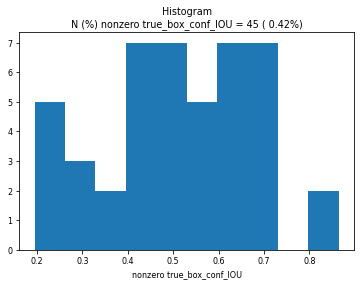

In [71]:
true_box_conf_IOU = calc_IOU_pred_true_assigned(
    true_box_conf,
    true_box_xy,
    true_box_wh,
    pred_box_xy,
    pred_box_wh
)

print("*" * 30 + "\ninput\n" + "*" * 30)    
print("true_box_conf = {}".format(true_box_conf))
print("true_box_xy   = {}".format(true_box_xy))
print("true_box_wh   = {}".format(true_box_wh))
print("pred_box_xy   = {}".format(pred_box_xy))
print("pred_box_wh   = {}".format(pred_box_wh))
print("*" * 30 + "\nouput\n" + "*" * 30) 
print("true_box_conf_IOU.shape = {}".format(true_box_conf_IOU.shape))

vec  = true_box_conf_IOU
pick = vec != 0
vec  = vec[pick]
plt.hist(vec)
plt.title("Histogram\nN (%) nonzero true_box_conf_IOU = {} ({:5.2f}%)".format(np.sum(pick), 100 * np.mean(pick)))
plt.xlabel("nonzero true_box_conf_IOU")
plt.show()

$\text{max}_{i',j'}(IOU_{prediction_{i,j}}^{ground truth_{i,j}})$

Find the anchor box with the highest IoU score, regardless of the ground truth anchor box that each object get assigned.

In [72]:
def calc_IOU_pred_true_best(pred_box_xy, pred_box_wh, true_boxes):
    """
    == input ==
    pred_box_xy : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    pred_box_wh : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    true_boxes  : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    
    == output == 
    
    best_ious
    
    for each iframe,
        best_ious[iframe,igridy,igridx,ianchor] contains
        
        the IOU of the object that is most likely included (or best fitted) 
        within the bounded box recorded in (grid_cell, anchor) pair
        
        NOTE: a same object may be contained in multiple (grid_cell, anchor) pair
              from best_ious, you cannot tell how may actual objects are captured as the "best" object
    """

    true_xy = true_boxes[..., 0:2] # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    true_wh = true_boxes[..., 2:4] # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)

    pred_xy = tf.expand_dims(pred_box_xy, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    pred_wh = tf.expand_dims(pred_box_wh, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)

    # (N batch, N grid_h, N grid_w, N anchor, 50) 
    iou_scores  =  get_intersect_area(
        true_xy,
        true_wh,
        pred_xy,
        pred_wh
    )
    
    # axis = 4 to get max by anchor box
    best_ious = tf.reduce_max(iou_scores, axis = 4) # (N batch, N grid_h, N grid_w, N anchor)

    return best_ious

******************************
input
******************************
true_box_wh   = [[[[[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   ...

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]]


  [[[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   ...

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]]


  [[[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   ...

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
  

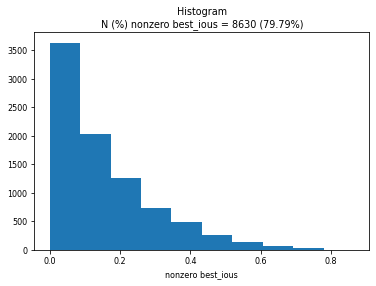

In [73]:
true_boxes = tf.constant(b_batch,dtype="float32")
best_ious = calc_IOU_pred_true_best(
    pred_box_xy,
    pred_box_wh,
    true_boxes
)
    
print("*" * 30 + "\ninput\n" + "*" * 30)    
print("true_box_wh   = {}".format(true_box_wh))
print("pred_box_xy   = {}".format(pred_box_xy))
print("pred_box_wh   = {}".format(pred_box_wh))
print("*" * 30 + "\nouput\n" + "*" * 30) 
print("best_ious.shape = {}".format(best_ious.shape))

vec  = best_ious
pick = vec!=0
vec  = vec[pick]
plt.hist(vec)
plt.title("Histogram\nN (%) nonzero best_ious = {} ({:5.2f}%)".format(np.sum(pick), 100 * np.mean(pick)))
plt.xlabel("nonzero best_ious")
plt.show()

Calculate $\lambda_{noobj} L_{i,j}^{noobj}$ and $\lambda_{obj} L_{i,j}^{obj}$

for each grid cell, calculate no object mask

$L_{i,j}^{noobj}$ is either
- 1 if $\text{max}_{i',j'}(IOU_{prediction_{i,j}}^{ground truth_{i,j}})$ < 0.6 and $C_{i,j} = 0$
- 0 else

In [74]:
def get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU, LAMBDA_NO_OBJECT, LAMBDA_OBJECT):
    """
    == input == 
    
    best_ious           : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf       : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU   : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    LAMBDA_NO_OBJECT    : 1.0
    LAMBDA_OBJECT       : 5.0
    
    == output ==
    conf_mask : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    
    conf_mask[iframe, igridy, igridx, ianchor] = 0
               when there is no object assigned in (grid cell, anchor) pair and the region seems useless i.e. 
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has no object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  NO_OBJECT_SCALE
               when there is no object assigned in (grid cell, anchor) pair but region seems to include some object
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has some object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  OBJECT_SCALE
              when there is an object in (grid cell, anchor) pair 
    """

    conf_mask = tf.cast(best_ious < 0.6, tf.float32) * (1 - true_box_conf) * LAMBDA_NO_OBJECT
    # penalize the confidence of the boxes, which are responbile for corresponding ground truth box
    conf_mask = conf_mask + true_box_conf_IOU * LAMBDA_OBJECT

    return conf_mask

In [75]:
conf_mask = get_conf_mask(
    best_ious, 
    true_box_conf, 
    true_box_conf_IOU,
    LAMBDA_NO_OBJECT, 
    LAMBDA_OBJECT
)

print("*"*30 + "\ninput\n" + "*"*30)  
print("best_ious         = {}".format(best_ious)) 
print("true_box_conf     = {}".format(true_box_conf))
print("true_box_conf_IOU = {}".format(true_box_conf_IOU))
print("LAMBDA_NO_OBJECT  = {}".format(LAMBDA_NO_OBJECT)) 
print("LAMBDA_OBJECT     = {}".format(LAMBDA_OBJECT))

print("*"*30 + "\noutput\n" + "*"*30)      
print("conf_mask shape = {}".format(conf_mask.shape))

******************************
input
******************************
best_ious         = [[[[1.07100024e-03 2.18523331e-02 1.05238274e-01 5.68802878e-02]
   [3.78593832e-04 2.57176701e-02 1.30540743e-01 7.28349239e-02]
   [1.61558948e-03 2.67224945e-02 1.49650753e-01 1.01658545e-01]
   ...
   [8.98063183e-04 2.47348491e-02 1.50389194e-01 8.85651261e-02]
   [4.27137566e-04 3.32694687e-02 1.25189751e-01 7.22132251e-02]
   [1.64375256e-03 2.14446988e-02 1.05616294e-01 6.42258525e-02]]

  [[7.12134829e-03 3.29215191e-02 1.31297097e-01 7.32453912e-02]
   [8.48584156e-03 5.08591905e-02 1.59056723e-01 9.79851410e-02]
   [7.89688341e-03 4.82698344e-02 1.84400707e-01 1.34302542e-01]
   ...
   [7.88071286e-03 5.21696731e-02 1.85915709e-01 1.23544246e-01]
   [8.29979870e-03 4.80049290e-02 1.60401240e-01 1.02648363e-01]
   [7.29092816e-03 3.37479450e-02 1.46433011e-01 8.24580938e-02]]

  [[1.30252810e-02 4.37434763e-02 1.48259789e-01 8.89857858e-02]
   [1.30739948e-02 6.47826269e-02 1.88474119e-01 

Finally we can calculate $loss_{i,j}^{c}$

$ = \frac{\lambda_{coord}}{N_{L^{obj}}}\ \Sigma_{i = 0}^{S^{2}}\ \Sigma_{j = 0}^{B}\ L_{i,j}^{obj}(IOU_{prediction_{i,j}}^{ground truth_{i,j}} - \hat{C}_{i,j})^{2}\ + \ \frac{\lambda_{noobj}}{N^{conf}}\ \Sigma_{i = 0}^{S^{2}}\ \Sigma_{j = 0}^{B}\ L_{i, j}^{noobj}(0 - \hat{C}_{i,j}) $

<br/>

$N^{conf} = \Sigma_{i=0}^{S^{2}}\ \Sigma_{j=0}^{B}\ L_{i,j}^{obj}\ + \ L_{i,j}^{noobj}(1 - L_{i,j}^{obj})$

In [76]:
def calc_loss_conf(conf_mask, true_box_conf_IOU, pred_box_conf):
    """
    == input ==
    
    conf_mask         : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    pred_box_conf     : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    """

    # the number of (grid cell, anchor) pair that has an assigned object or
    # that has no assigned object but some objects may be in bounding box.
    # N conf
    nb_conf_box = tf.reduce_sum(tf.cast(conf_mask > 0.0, tf.float32))
    loss_conf = tf.reduce_sum(
        tf.square(true_box_conf_IOU - pred_box_conf) * conf_mask
    ) / (nb_conf_box + 1e-6) / 2.

    return loss_conf

In [77]:
print("*"*30 + "\ninput\n" + "*"*30)  
print("conf_mask         = {}".format(conf_mask)) # get_conf_mask()
print("true_box_conf_IOU = {}".format(true_box_conf_IOU)) # calc_IOU_pred_true_assigned()
print("pred_box_conf     = {}".format(pred_box_conf))

loss_conf = calc_loss_conf(conf_mask, true_box_conf_IOU, pred_box_conf)
    
print("*"*30 + "\noutput\n" + "*"*30)      
print("loss_conf = {:5.4f}".format(loss_conf))

******************************
input
******************************
conf_mask         = [[[[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  ...

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]]


 [[[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.

### Custom Loss Function `custom_loss(y_true, y_pred)`

In [78]:
def custom_loss(y_true, y_pred):
    """
    y_true : (N batch, N grid h, N grid w, N anchor, 4 + 1 + N classes)
    y_true[irow, i_gridh, i_gridw, i_anchor, :4] = center_x, center_y, w, h
    
        center_x : The x coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        center_y : The y coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
        w        : The width of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        h        : The height of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
                   
    y_true[irow, i_gridh, i_gridw, i_anchor, 4] = ground truth confidence
        
        ground truth confidence is 1 if object exists in this (anchor box, gird cell) pair
    
    y_true[irow, i_gridh, i_gridw, i_anchor, 5 + iclass] = 1 if the object is in category  else 0
    """

    total_recall = tf.Variable(0.)

    # Step 1: Adjust prediction output
    cell_grid   = get_cell_grid(GRID_W, GRID_H, BATCH_SIZE, BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred,cell_grid, ANCHORS)

    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)

    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(
        true_box_conf,
        LAMBDA_COORD,
        true_box_xy,
        pred_box_xy,
        true_box_wh,
        pred_box_wh
    )

    # Step 4: Calculate loss for the class probabilities
    loss_class = calc_loss_class(true_box_conf, LAMBDA_CLASS, true_box_class, pred_box_class)

    # Step 5: For each (grid cell, anchor) pair,
    #         calculate the IoU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(
        true_box_conf,
        true_box_xy,
        true_box_wh,
        pred_box_xy,
        pred_box_wh
    )

    # Step 6: For each predicted bounded box from (grid cell, anchor box),
    #         calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.
    best_ious = calc_IOU_pred_true_best(pred_box_xy, pred_box_wh, true_boxes)

    # Step 7: For each grid cell, calculate the L_{i,j}^{noobj}
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU, LAMBDA_NO_OBJECT, LAMBDA_OBJECT)

    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask, true_box_conf_IOU, pred_box_conf)

    loss = loss_xywh + loss_conf + loss_class
    return loss

In [79]:
print(y_batch.dtype, y_pred.dtype)

true_boxes = tf.Variable(np.zeros_like(b_batch), dtype="float32")
loss = custom_loss(y_batch.astype('float32'), y_pred.astype('float32'))

print('loss', loss)

float64 float64
loss tf.Tensor(6.039035, shape=(), dtype=float32)


<br/>

# 5. Training The Model

https://fairyonice.github.io/Part_5_Object_Detection_with_Yolo_using_VOC_2012_data_training.html

In [80]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           norm_1[0][0]                     
_______________________________________________________________________________________

### Initialize the weights

In [81]:
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

dir_log = "/logs"
try:
    os.makedirs(dir_log)
except:
    pass

generator_config["BATCH_SIZE"] = BATCH_SIZE

early_stop = EarlyStopping(
    monitor = "loss",
    min_delta = 0.001,
    patience = 3,
    mode = "min",
    verbose = 1,
)

checkpoint = ModelCheckpoint(
    './gdrive/My\ Drive/Colab\ Data/weights_yolo_on_voc2012.h5',
    monitor = "loss",
    verbose = 1,
    save_best_only = True,
    mode = "min",
    period = 1
)

optimizer = Adam(lr = 0.5e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)
model.compile(loss = custom_loss, optimizer = optimizer)

### Train the model

In [82]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

# model.load_weights('./gdrive/My\ Drive/Colab\ Data/weights_yolo_on_voc2012.h5')
model.fit_generator(
    generator = train_batch_generator,
    steps_per_epoch = len(train_batch_generator),
    epochs = 50,
    verbose = 1,
    callbacks = [early_stop, checkpoint],
    max_queue_size = 3
)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/50
 326/1071 [========>.....................] - ETA: 6:49 - loss: 2.6944

<br/>

# 6. Evaluating

https://fairyonice.github.io/Part_6_Object_Detection_with_Yolo_using_VOC_2012_data_inference_image.html

Perform detection on sample image

In [ ]:
imageReader = ImageReader(IMAGE_H, IMAGE_W = IMAGE_W, norm = labmda image : image / 255.)
out = imageReader.fit(train_image_folder + "/2007_005430.jpg")

In [ ]:
print(out.shape)

X_test = np.expand_dims(out,0)

print(X_test.shape)

# handle the hack input
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
y_pred = model.predict([X_test,dummy_array])

print(y_pred.shape)

Rescale the network output

In [ ]:
class OutputRescaler(object):
    def __init__(self, ANCHORS):
        self.ANCHORS = ANCHORS

    def _sigmoid(self, x):
        return 1. / (1. + np.exp(-x))

    def _softmax(self, x, axis = -1, t = -100.):
        x = x - np.max(x)

        if np.min(x) < t:
            x = x / np.min(x) * t

        e_x = np.exp(x)
        return e_x / e_x.sum(axis, keepdims = True)

    def get_shifting_matrix(self,netout):
        
        GRID_H, GRID_W, BOX = netout.shape[:3]
        no = netout[..., 0]
        
        ANCHORSw = self.ANCHORS[::2]
        ANCHORSh = self.ANCHORS[1::2]
       
        mat_GRID_W = np.zeros_like(no)
        for igrid_w in range(GRID_W):
            mat_GRID_W[:, igrid_w, :] = igrid_w

        mat_GRID_H = np.zeros_like(no)
        for igrid_h in range(GRID_H):
            mat_GRID_H[igrid_h, :, :] = igrid_h

        mat_ANCHOR_W = np.zeros_like(no)
        for ianchor in range(BOX):    
            mat_ANCHOR_W[:, :, ianchor] = ANCHORSw[ianchor]

        mat_ANCHOR_H = np.zeros_like(no) 
        for ianchor in range(BOX):    
            mat_ANCHOR_H[:, :, ianchor] = ANCHORSh[ianchor]

        return mat_GRID_W, mat_GRID_H, mat_ANCHOR_W, mat_ANCHOR_H

    def fit(self, netout):    
        """
        netout  : np.array of shape (N grid h, N grid w, N anchor, 4 + 1 + N class)
        
        a single image output of model.predict()
        """

        GRID_H, GRID_W, BOX = netout.shape[:3]
        
        (mat_GRID_W,
         mat_GRID_H,
         mat_ANCHOR_W,
         mat_ANCHOR_H) = self.get_shifting_matrix(netout)

        # bounding box parameters
        netout[..., 0]   = (self._sigmoid(netout[..., 0]) + mat_GRID_W) / GRID_W # x      unit: range between 0 and 1
        netout[..., 1]   = (self._sigmoid(netout[..., 1]) + mat_GRID_H) / GRID_H # y      unit: range between 0 and 1
        netout[..., 2]   = (np.exp(netout[..., 2]) * mat_ANCHOR_W) / GRID_W      # width  unit: range between 0 and 1
        netout[..., 3]   = (np.exp(netout[..., 3]) * mat_ANCHOR_H) / GRID_H      # height unit: range between 0 and 1
        # rescale the confidence to range 0 and 1 
        netout[..., 4]   = self._sigmoid(netout[..., 4])
        expand_conf      = np.expand_dims(netout[...,4],-1) # (N grid h , N grid w, N anchor , 1)

        # rescale the class probability to range between 0 and 1
        # Pr(object class = k) = Pr(object exists) * Pr(object class = k |object exists)
        #                      = Conf * P^c

        netout[..., 5:]  = expand_conf * self._softmax(netout[..., 5:])
        # ignore the class probability if it is less than obj_threshold 
    
        return netout

In [ ]:
netout         = y_pred[0]
outputRescaler = OutputRescaler(ANCHORS = ANCHORS)
netout_scale   = outputRescaler.fit(netout)

In [ ]:
def find_high_class_probability_bbox(netout_scale, obj_threshold):
    '''
    == Input == 
    netout : y_pred[i] np.array of shape (GRID_H, GRID_W, BOX, 4 + 1 + N class)
    
             x, w must be a unit of image width
             y, h must be a unit of image height
             c must be in between 0 and 1
             p^c must be in between 0 and 1
    == Output ==
    
    boxes  : list containing bounding box with Pr(object is in class C) > 0 for at least in one class C 
    
             
    '''
    GRID_H, GRID_W, BOX = netout_scale.shape[:3]
    
    boxes = []
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row, col, b, 5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row, col, b, :4]
                    confidence = netout_scale[row, col, b, 4]
                    box = BoundBox(x - w / 2, y - h / 2, x + w / 2, y + h / 2, confidence, classes)
                    if box.get_score() > obj_threshold:
                        boxes.append(box)

    return boxes

In [ ]:
obj_threshold = 0.015
boxes_tiny_threshold = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("obj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes_tiny_threshold),obj_threshold))

obj_threshold = 0.03
boxes = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("\nobj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes),obj_threshold))

Visualize many bounding box by having small obj_threshold value

In [ ]:
import cv2, copy
import seaborn as sns

def draw_boxes(image, boxes, labels, obj_baseline=0.05,verbose=False):
    '''
    image : np.array of shape (N height, N width, 3)
    '''
    def adjust_minmax(c,_max):
        if c < 0:
            c = 0   
        if c > _max:
            c = _max
        return c
    
    image = copy.deepcopy(image)
    image_h, image_w, _ = image.shape
    score_rescaled  = np.array([box.get_score() for box in boxes])
    score_rescaled /= obj_baseline
    
    colors = sns.color_palette("husl", 8)

    for sr, box,color in zip(score_rescaled,boxes, colors):
        xmin = adjust_minmax(int(box.xmin * image_w), image_w)
        ymin = adjust_minmax(int(box.ymin * image_h), image_h)
        xmax = adjust_minmax(int(box.xmax * image_w), image_w)
        ymax = adjust_minmax(int(box.ymax * image_h), image_h)
 
        
        text = "{:10} {:4.3f}".format(labels[box.label], box.get_score())
        if verbose:
            print("{} xmin={:4.0f},ymin={:4.0f},xmax={:4.0f},ymax={:4.0f}".format(text, xmin, ymin, xmax, ymax, text))

        cv2.rectangle(image, 
                      pt1=(xmin,ymin), 
                      pt2=(xmax,ymax), 
                      color=color, 
                      thickness=sr)
        cv2.putText(img       = image, 
                    text      = text, 
                    org       = (xmin+ 13, ymin + 13),
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale = 1e-3 * image_h,
                    color     = (1, 0, 1),
                    thickness = 1)
        
    return image

In [ ]:
print("Plot with low object threshold")
ima = draw_boxes(X_test[0],boxes_tiny_threshold,LABELS,verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.title("Plot with low object threshold")
plt.show()

print("Plot with high object threshold")
ima = draw_boxes(X_test[0],boxes,LABELS,verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.title("Plot with high object threshold")
plt.show()

Non-max suppression to choose the bounding box with the highest IoU

In [ ]:
def nonmax_suppression(boxes,iou_threshold,obj_threshold):
    '''
    boxes : list containing "good" BoundBox of a frame
            [BoundBox(),BoundBox(),...]
    '''
    bestAnchorBoxFinder    = BestAnchorBoxFinder([])
    
    CLASS    = len(boxes[0].classes)
    index_boxes = []   
    # suppress non-maximal boxes
    for c in range(CLASS):
        # extract class probabilities of the c^th class from multiple bbox
        class_probability_from_bbxs = [box.classes[c] for box in boxes]

        #sorted_indices[i] contains the i^th largest class probabilities
        sorted_indices = list(reversed(np.argsort( class_probability_from_bbxs)))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            # if class probability is zero then ignore
            if boxes[index_i].classes[c] == 0:  
                continue
            else:
                index_boxes.append(index_i)
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    # check if the selected i^th bounding box has high IOU with any of the remaining bbox
                    # if so, the remaining bbox' class probabilities are set to 0.
                    bbox_iou = bestAnchorBoxFinder.bbox_iou(boxes[index_i], boxes[index_j])
                    if bbox_iou >= iou_threshold:
                        classes = boxes[index_j].classes
                        classes[c] = 0
                        boxes[index_j].set_class(classes)
                        
    newboxes = [ boxes[i] for i in index_boxes if boxes[i].get_score() > obj_threshold ]                
    
    return newboxes

In [ ]:
iou_threshold = 0.01
final_boxes = nonmax_suppression(boxes,iou_threshold=iou_threshold,obj_threshold=obj_threshold)
print("{} final number of boxes".format(len(final_boxes)))

In [ ]:
ima = draw_boxes(X_test[0],final_boxes,LABELS,verbose=True)

figsize = (15,15)

plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.show()

More examples

In [ ]:
np.random.seed(1)
Nsample   = 2
image_nms = list(np.random.choice(os.listdir(train_image_folder),Nsample))

In [ ]:
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
imageReader    = ImageReader(IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)
X_test         = []

for img_nm in image_nms:
    _path    = os.path.join(train_image_folder,img_nm)
    out      = imageReader.fit(_path)
    X_test.append(out)

X_test = np.array(X_test)

## model
dummy_array    = np.zeros((len(X_test),1,1,1,TRUE_BOX_BUFFER,4))
y_pred         = model.predict([X_test,dummy_array])

for iframe in range(len(y_pred)):
        netout         = y_pred[iframe] 
        netout_scale   = outputRescaler.fit(netout)
        boxes          = find_high_class_probability_bbox(netout_scale,obj_threshold)
        if len(boxes) > 0:
            final_boxes    = nonmax_suppression(boxes,
                                                iou_threshold=iou_threshold,
                                                obj_threshold=obj_threshold)
            ima = draw_boxes(X_test[iframe],final_boxes,LABELS,verbose=True)
            plt.figure(figsize=figsize)
            plt.imshow(ima); 
            plt.show()

Check the follow post to do detection on video

https://fairyonice.github.io/Part_7_Object_Detection_with_Yolo_using_VOC_2012_data_inference_video.html